In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import networkx as nx
import toolz as tz

from eden.util import configure_logging
import logging
logger = logging.getLogger()
configure_logging(logger, verbosity=1)

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')

# Data setup

________________________________________________________________________________
Dataset 624249 info:

qHTS screen for small molecules that inhibit ELG1-dependent DNA repair in human embryonic kidney (HEK293T) cells expressing luciferase-tagged ELG1: Hit Confirmation using MMS Stimulated ELG1
Reading from file: PUBCHEM/AID624249_active.sdf
Reading from file: PUBCHEM/AID624249_inactive.sdf

Positive graphs
original size:355
random sample:355
removed disconnected:339
size filter:307
outlier removal:246
random sample:246

Negative graphs
original size:173
random sample:173
removed disconnected:170
size filter:154
outlier removal:130
random sample:130
--------------------------------------------------------------------------------
Selecting a good cluster of molecular graphs in 4 attempts. This might take a while...
0.323   
0.210   
0.360   
0.247   
Generated 135 graphs


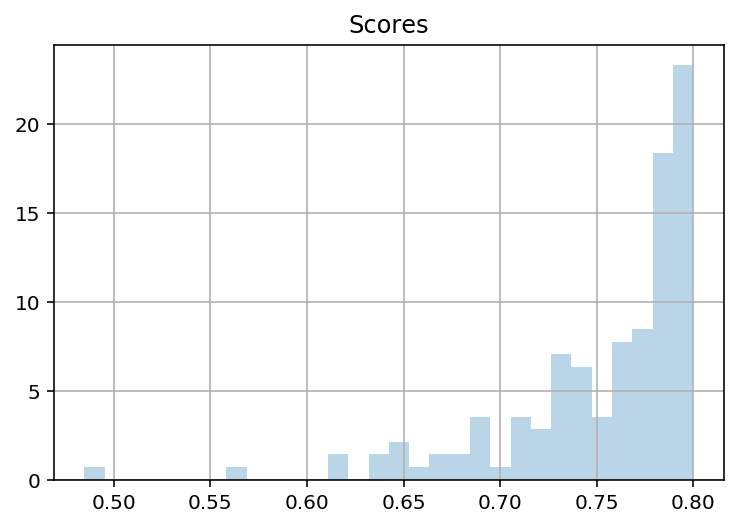

Best graphs in initial sample of 50


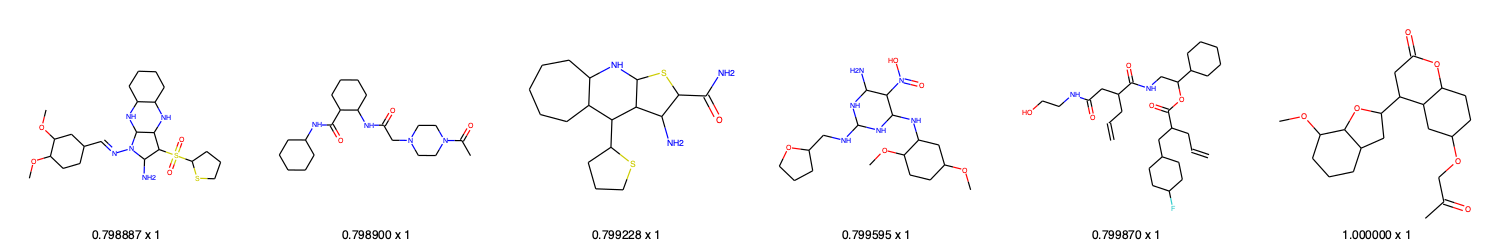

CPU times: user 9min 43s, sys: 7.94 s, total: 9min 51s
Wall time: 9min 58s


In [2]:
%%time

EXPERIMENT_TYPE = 'CHEMICAL'

if EXPERIMENT_TYPE == 'ARTIFICIAL':
    from utils_artificial import build_artificial_experiment
    from utils_artificial import display_ktop_graphs, draw_graphs, draw_history
    from utils_artificial import display_score_statistics
    from utils_artificial import remove_duplicates
    res = build_artificial_experiment(
        GRAPH_TYPE='tree', # path  tree  degree  regular  dense
        instance_size=20,
        n_init_instances=10, 
        n_domain_instances=100,
        alphabet_size=4, 
        max_score_threshold=.8,
        oracle_func=None,
        neighborhood_estimators=['node_add','node_smooth','edge_swap','edge_expand','edge_contract'],
        n_iterations=2, 
        n_neighbors_per_estimator_per_iteration=2)
    
if EXPERIMENT_TYPE == 'CHEMICAL':
    from utils_chemoinformatics import build_chemical_experiment
    from utils_chemoinformatics import display_ktop_graphs, draw_graphs, draw_history
    from utils_chemoinformatics import display_score_statistics
    from utils_chemoinformatics import remove_duplicates
    res = build_chemical_experiment(
        assay_id='624249',  # assay_ids = ['624466','492992','463230','651741','743219','588350','492952','624249','463213','2631','651610']
        n_init_instances=50, 
        n_domain_instances=300,
        max_score_threshold=.8,
        n_targets=4)

init_graphs, domain_graphs, oracle_func, target_graph = res
print('Generated %d graphs'%len(domain_graphs))
display_score_statistics(domain_graphs, oracle_func)

print('Best graphs in initial sample of %d'%len(init_graphs))
display_ktop_graphs(init_graphs+[target_graph], oracle_func, n_max=6)

# Experiments

In [3]:
from ego.optimization.optimize import optimizer_setup, optimize

# performance monitor
from utils_monitor import make_monitor
monitor = make_monitor(target_graph=target_graph, oracle_func=oracle_func, draw_graphs=draw_graphs, draw_history=draw_history)

from ego.setup import *
decomposition_function = do_decompose(
    decompose_nodes_and_edges, 
    decompose_path(length=2), 
    decompose_neighborhood, 
    decompose_neighborhood(radius=2), 
    decompose_neighborhood(radius=3), 
    decompose_cycles)

decomposition_score_estimator = decomposition_function
decomposition_part_importance_graph_grammar = do_decompose(decompose_neighborhood, decompose_neighborhood(radius=2), decompose_neighborhood(radius=3))
decomposition_adaptive_graph_grammar_base = decompose_neighborhood
decomposition_adaptive_graph_grammar_approx = do_decompose(decompose_nodes_and_edges, decompose_neighborhood)
decomposition_feasibility_estimator = do_decompose(decompose_neighborhood, decompose_cycles)

graphs = init_graphs[:]

In [ ]:
%%time

from ego.optimization.optimize import optimizer_setup, optimize

# setup
neighborhood_estimators, score_estimator, feasibility_estimator = optimizer_setup(
    #estimators------------------------------------------------------------------
    use_RandomForest_estimator=True,
    use_Linear_estimator=False,
    use_EI_estimator=False,
    use_UCB_estimator=False,
    n_estimators=200,
    exploration_vs_exploitation=0,
    decomposition_score_estimator=decomposition_score_estimator,
    
    use_feasibility_estimator=True,
    decomposition_feasibility_estimator=decomposition_feasibility_estimator,
    domain_graphs_feasibility_estimator=domain_graphs,
    
    #edges------------------------------------------------------------------
    use_edge_swapping=True, n_neighbors_edge_swapping=None, n_edge_swapping=1,
    use_edge_label_swapping=False, n_neighbors_edge_label_swapping=None, n_edge_label_swapping=1,
    use_edge_label_mutation=True, n_neighbors_edge_mutation=None, n_edge_mutation=1,
    use_edge_move=True, n_neighbors_edge_move=None, n_edge_move=1,
    use_edge_removal=False, n_neighbors_edge_removal=None, n_edge_removal=1,
    use_edge_addition=False, n_neighbors_edge_addition=100, n_edge_addition=1,
    use_edge_expand=True, n_neighbors_edge_expand=100, n_edge_expand=1,
    use_edge_contract=True, n_neighbors_edge_contract=100, n_edge_contract=1,
    
    #nodes------------------------------------------------------------------
    use_node_label_swapping=True, n_neighbors_node_label_swapping=None, n_node_label_swapping=1,
    use_node_label_mutation=True, n_neighbors_node_mutation=None, n_node_mutation=1,
    use_node_removal=True, n_neighbors_node_removal=None, n_node_removal=1,
    use_node_addition=True, n_neighbors_node_addition=100, n_node_addition=1,
    use_node_smooth=True,n_neighbors_node_smooth=100, n_node_smooth=1,

    #graph grammars------------------------------------------------------------------
    use_part_importance_graph_grammar=False,
    n_neighbors_part_importance_graph_grammar=None,
    conservativeness_part_importance_graph_grammar=3,
    context_size_part_importance_graph_grammar=4,
    decomposition_part_importance_graph_grammar=decomposition_part_importance_graph_grammar,
    domain_graphs_part_importance_graph_grammar=domain_graphs,

    use_adaptive_graph_grammar=True,
    n_neighbors_adaptive_graph_grammar=None,
    conservativeness_adaptive_graph_grammar=2,
    context_size_adaptive_graph_grammar=1,
    part_size_adaptive_graph_grammar=4,
    decomposition_adaptive_graph_grammar_base=decomposition_adaptive_graph_grammar_base,
    decomposition_adaptive_graph_grammar_approx=decomposition_adaptive_graph_grammar_approx)



# run optimization
graphs = optimize(
    graphs, 
    oracle_func, 
    score_estimator=score_estimator, 
    feasibility_estimator=feasibility_estimator,
    neighborhood_estimators=neighborhood_estimators,
    
    n_iter=100, 
    n_queries_to_oracle_per_iter=200,
    frac_instances_to_remove_per_iter=.5,
    sample_size_to_perturb=8, 
    n_steps_driven_by_estimator=2,
    sample_size_for_grammars=50,
    monitor=monitor)

Fitting feasibility estimator on 135 graphs

- iteration: 1
Score estimator fitted on 50 graphs in 0.4 min
From a biased draw of 8 samples from 50 graphs...
1:1/11)             EdgeSwap: 397 novel graphs out of  783 generated    8 selected graphs   best predicted score:0.796   time:4.7 min
2:1/11)             EdgeSwap: 340 novel graphs out of  686 generated  200 selected graphs   best predicted score:0.797   time:3.6 min
1:2/11)    EdgeLabelMutation:  61 novel graphs out of  297 generated    8 selected graphs   best predicted score:0.794   time:0.9 min
2:2/11)    EdgeLabelMutation:  69 novel graphs out of  323 generated   69 selected graphs   best predicted score:0.794   time:1.3 min
1:3/11)             EdgeMove:2580 novel graphs out of 3965 generated    8 selected graphs   best predicted score:0.797   time:24.0 min
2:3/11)             EdgeMove:2623 novel graphs out of 3890 generated  200 selected graphs   best predicted score:0.798   time:23.9 min
1:4/11)           EdgeExpand: 164 nov

In [ ]:
# display results
print('Target')
display_ktop_graphs([target_graph], oracle_func, n_max=6)

print('Evolution of best synthesized graph in set of size %d'%len(graphs))
draw_history(graphs, oracle_func)

print('Best synthesized graphs in set of size %d'%len(graphs))
display_ktop_graphs(graphs, oracle_func, n_max=6*2)

---